In [114]:
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import time
import mlpModel 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [ ]:
sc.settings.verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Prepping Data

In [97]:
#obtain data from file
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

In [96]:
adata.obs['perturbation_name'].iloc[0]

'control'

In [118]:
#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()
parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]

In [119]:
#multilabel encode the data 
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    ddata, 
    labels_int, 
    test_size=0.2, 
    random_state=67, #SIX SEVEENNNNNNNNNN
    stratify=labels_int
)

In [130]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Running Model

In [134]:
input_size = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.001
num_epochs = 15

model = mlpModel.MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-5)

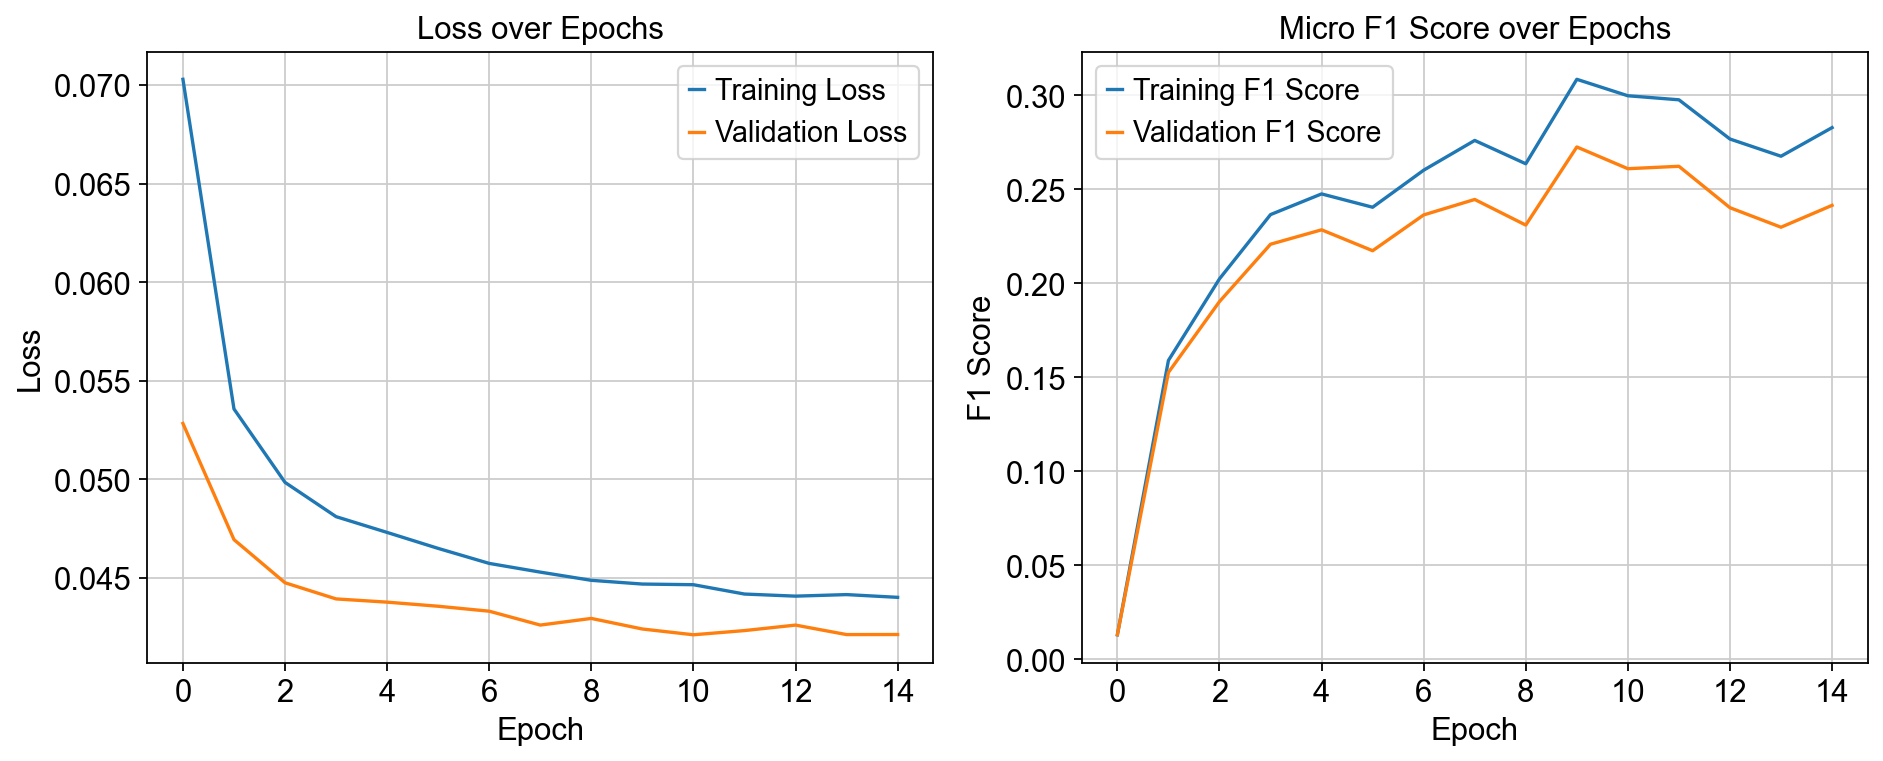

Epoch [15/15], Loss: 0.0405

Training Complete. Final Validation F1 Score: 0.2414


In [135]:
train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
display(fig)


for epoch in range(num_epochs):
    model.train()
    current_train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(train_loader))

    model.eval()
    current_test_loss = 0.0
    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_preds.append(preds.numpy())
            all_test_labels.append(labels.numpy())
        
        # Evaluate on training set (to compare train vs test performance)
        for inputs, labels in train_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.numpy())
            all_train_labels.append(labels.numpy())
        
    test_losses.append(current_test_loss / len(test_loader))
    
    # Calculate F1 score for this epoch
    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    test_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    

    # Clear the previous plot
    ax1.clear()
    ax2.clear()
    
    # Plot Loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot F1 Score (Accuracy)
    ax2.plot(train_f1_scores, label='Training F1 Score')
    ax2.plot(test_f1_scores, label='Validation F1 Score')
    ax2.set_title('Micro F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    
    fig.tight_layout()
    # Redraw the plot in the same cell
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1) # Small pause to allow plot to render

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Close the figure after the loop is done
plt.close(fig)

print(f"\nTraining Complete. Final Validation F1 Score: {test_f1_scores[-1]:.4f}")

